## Расширенный вариационный автоэнкодер  

Общая архитектура CVAE.

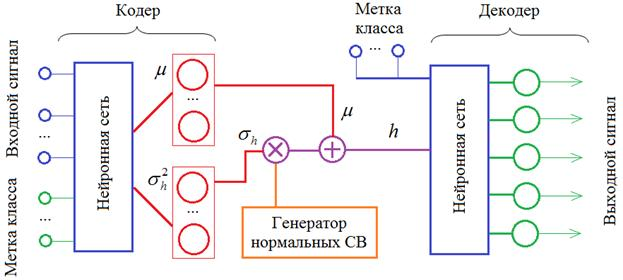

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout, concatenate
from keras.models import Model
from keras.utils import to_categorical

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Загрузка и стандартизация данных из mnist  

<code>hidden_size</code> - размер скрытого пространства / число нейронов скрытого пространства  
<code>num_classes</code> - число классов  
<code>batch_size</code>- размер батча

In [6]:
hidden_size = 2
num_classes = 10 # 10 цифр только
batch_size = 100 # кратно 60К и 10К

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

Формирование структуры расширенного автоэнкодера  
<code>lb</code>, <code>lb_dec</code> - входные слои для метки класса  
<code>x = concatenate([fl, lb])</code> - объединение двух входов (изобр. и метки классов)

In [57]:
def dropoutAndBatch(x):
    return Dropout(0.3)(BatchNormalization()(x))


def noiser(args):
    global z_mean, z_ln_var
    z_mean, z_ln_var = args
    N = K.random_normal((batch_size, hidden_size), mean=0., stddev=1.0)
    return K.exp(z_ln_var / 2) * N + z_mean


# кодер
input_img = Input((28, 28, 1))
fl = Flatten()(input_img)
lb = Input((num_classes,))
x = concatenate([fl, lb])
x = Dense(256, activation='relu')(x)
x = dropoutAndBatch(x)
x = Dense(128, activation='relu')(x)
x = dropoutAndBatch(x)

z_mean2 = Dense(hidden_size)(x)
z_ln_var = Dense(hidden_size)(x)


h = Lambda(noiser, output_shape=(hidden_size,))([z_mean2, z_ln_var])

# декодер
input_dec = Input((hidden_size,))
lb_dec = Input((num_classes,))
d = concatenate([input_dec, lb_dec])
d = Dense(128, activation='relu')(d)
d = dropoutAndBatch(d)
d = Dense(256, activation='relu')(d)
d = dropoutAndBatch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)


encoder = Model([input_img, lb], h, name='encoder')
decoder = Model([input_dec, lb_dec], decoded, name='decoder')
cvae = Model([input_img, lb, lb_dec], decoder([encoder([input_img, lb]), lb_dec]), name='cvae')


z_meaner = Model([input_img, lb], z_mean2)
tr_style = Model([input_img, lb, lb_dec], decoder([z_meaner([input_img, lb]), lb_dec]), name='tr_style')


Функция потерь, с использованием формулы Кульбака-Лейблера

In [58]:
def cvae_loss(x, y):
    x = K.reshape(x, (batch_size, 28*28))
    y = K.reshape(y, (batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1 + z_ln_var - K.square(z_mean) - K.exp(z_ln_var), axis=-1) # формула Кульбака-Лейблера
    return loss + kl_loss


cvae.compile(optimizer='adam', loss=cvae_loss)

Обучение модели.  
<code>[x_train, y_train_cat, y_train_cat]</code> -> [обучающая выборка, метки для кодера, метки для декодера].  
y_train_cat одинаковые, тк при обучении должна быть одна метка для кодера и такая же метка для декодера.  
[...], <code>x_train</code>, ... -> тк на выходе ждем такую же цифру, как и на входе.  

In [59]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
600/600 [==============================] - 6s 7ms/step - loss: 71.9538
Epoch 2/5
600/600 [==============================] - 4s 6ms/step - loss: 41.3378
Epoch 3/5
600/600 [==============================] - 4s 6ms/step - loss: 38.5969
Epoch 4/5
600/600 [==============================] - 4s 6ms/step - loss: 37.2190
Epoch 5/5
600/600 [==============================] - 4s 6ms/step - loss: 36.2852


Распределение точек векторов скрытого состояния для тестового набора изображений.

100/100 [==============================] - 0s 2ms/step


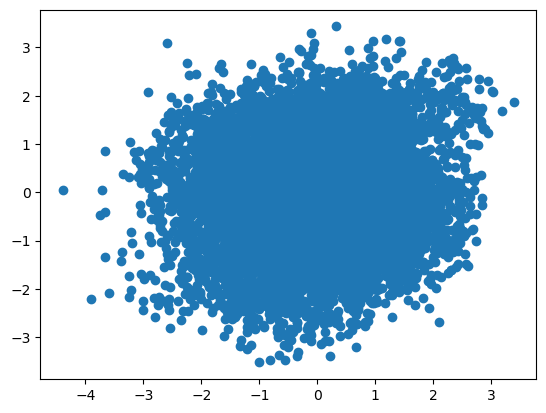

In [60]:
lb = lb_dec = y_test_cat
h = encoder.predict([x_test, lb], batch_size=batch_size)
plt.scatter(h[:,0], h[:,1])

Преобразование точек исходного пространства в изображение (декодер).  

<code>input_lb</code> = array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])  
<code>h</code> = array([[0., 0.]]); (значения для каждого элемента от -1 до 1).  
<code>n</code> -> размер области для скрытого состояния  

<code>input_lb[0, 2] = 1</code> - индекс = 1 в разряженном векторе, input_lb[0, 2] - на позиции 2.  
Но тут можем использовать не только [0, 2] - который соответствует "2". Если взять, например, [0, 5] - это будет соответствовать "5". Т.е одна и так же точка скрытого пространства может интерпритироваться как различные цифры, в зависимости от метки передаваемого класса.   

В строке <code>h[0, :] = [3 * i/n, 3 * j/n]</code> умножение на 3 делается для того, чтобы получить более широкий диапазон значений входных данных для модели.

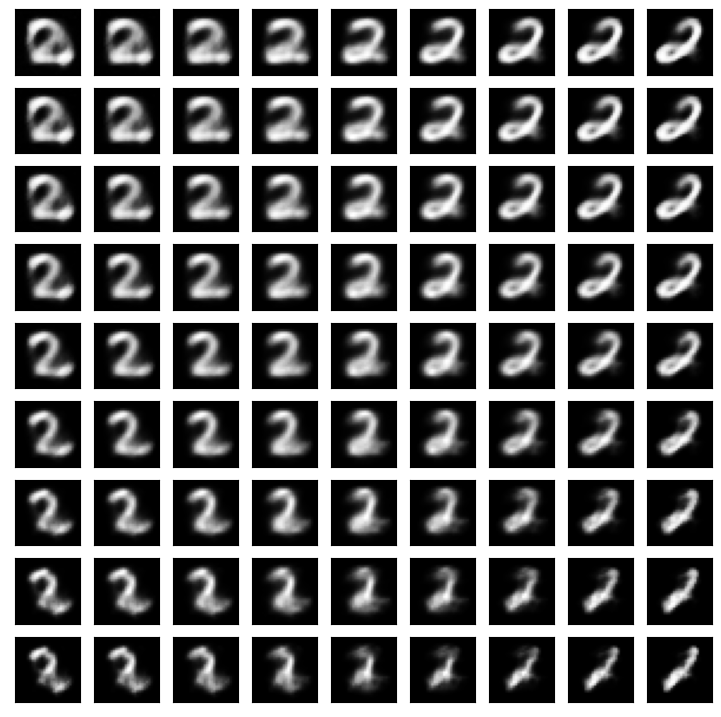

In [89]:
input_lb = np.zeros((1, num_classes))
input_lb[0, 2] = 1

h = np.zeros((1, hidden_size))
n = 4
total = 2*n+1
num = 1
plt.figure(figsize=(total, total))

for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        h[0, :] = [3*i/n, 3*j/n]
        img = decoder.predict([h, input_lb], verbose=False)
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    

Для различных написаний цифр 5 генерируем другие цифры (от 0 до 9).  
Они будут стараться повторить наклон, толщину и тд , исходной цифры 5.  
=> каждый конкретный вектор скрытого пространства описывает некие общие хар-ки различных изображениц (наклон, толщину и тд).

Т.е. можем сложные входные данные (разных размерностей) отображать в пространство с гораздо меньшими размерами и каждая точка этого скрытого пространства будет определять вполне определенные характерные свойства входного сигнала.

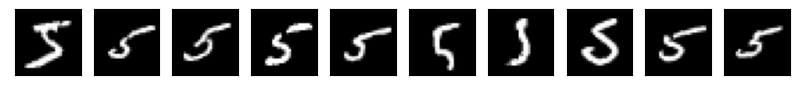

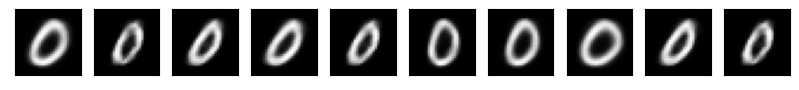

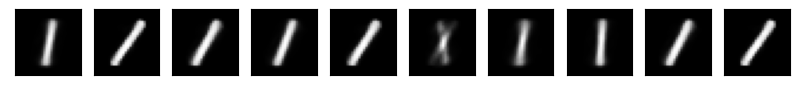

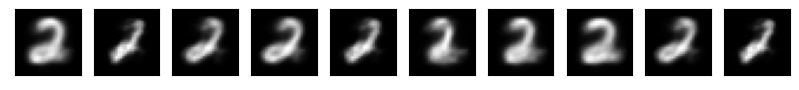

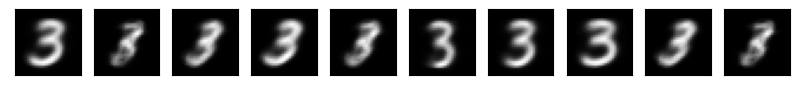

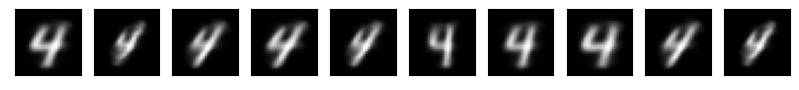

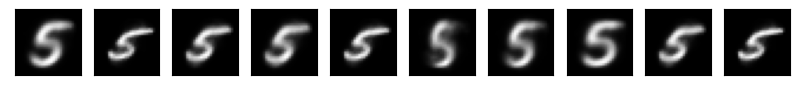

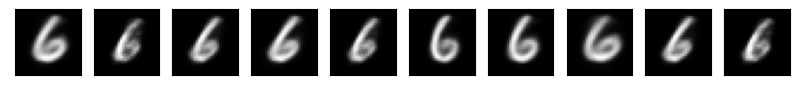

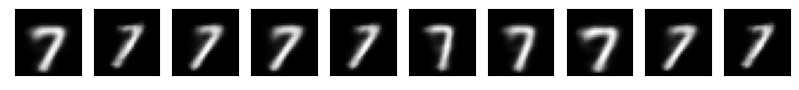

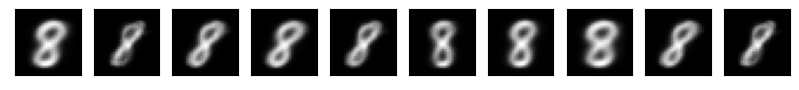

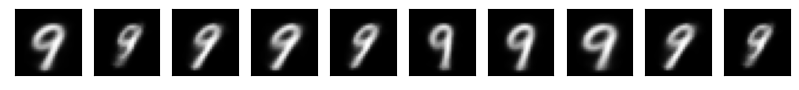

In [83]:
def plotDigits(*images):
    images = [x.squeeze() for x in images] # удаляем размерность 1 из каждого изображения
    n = min([x.shape[0] for x in images])
    ln = len(images)
    
    plt.figure(figsize=(n, ln))
    for i in range(n):
        for j in range(ln):
            ax = plt.subplot(ln, n, j*n + i + 1) #  создание подграфика в позиции (j, i) 
            plt.imshow(images[j][i], cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    

dig1 = 5
num = 10

X = x_train[y_train == dig1][:num] # выборка из 10 различных 5-к
lb_1 = np.zeros((num, num_classes))
lb_1[:, dig1] = 1

plotDigits(X) # выводим исходное значение

for i in range(num_classes):
    lb_2 = np.zeros((num, num_classes))
    lb_2[:, i] = 1
    
    Y = tr_style.predict([X, lb_1, lb_2], verbose=False)
    plotDigits(Y) 
